## Maaslin 2 Analysis of GO Terms for COVIRT19

 Lets install some R packages that we are gonna need to run this analysis

#if(!requireNamespace("BiocManager", quietly = TRUE))
#install.packages("BiocManager")

In [ ]:
#if(!requireNamespace("BiocManager", quietly = TRUE)) 
#    install.packages("BiocManager")

In [ ]:
#BiocManager::install("Maaslin2")
#BiocManager::install('DESeq2')
#BiocManager::install('phyloseq')
#BiocManager::install('microbiome')
#BiocManager::install("DirichletMultinomial")

In [ ]:
#install.packages("remotes")
#remotes::install_github("mikemc/speedyseq")
#install.packages('ggpubr')
#install.packages('viridis')
#install.packages('mosaic')

Now lets load our libraries and set out environment

In [ ]:
library(tidyverse)
library(phyloseq)
library(microbiome)
library(DESeq2)
library(Maaslin2)
library(parallel)
library(DirichletMultinomial)
library(pheatmap)
library(ggpubr)
library(viridis)
library(mosaic)

In [ ]:
getwd()
setwd('/home/jovyan/')

In [ ]:
raw<-as_tibble(read.table("Combined_BALF_GO_Terms_parent_propagated.tsv", sep = "\t", row.names = NULL, header = T, quote = "", comment.char = ""))

A tibble: 47,233 x 2,020     # good so far now
do a little regex and fix some stuff

In [ ]:
colnames(raw)<-gsub("NA_tax","unclass", colnames(raw))%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")

Transform the raw table by type of count (euk, term, bac, arc)

In [ ]:
df<-raw %>%
  select(GO_term,namespace,depth,name,ends_with("_counts"))%>%
  pivot_longer(cols = -c(GO_term,namespace,depth,name),
               names_to =  c("sample","type","abund"),#c("Total", "Archaea","Bacteria","Eukarya", "Viridae", "Unclassified"),
               names_pattern = "(.*)_(.*)_(.*)")%>%
  select(-abund)%>%
  filter(value>1)%>%
  pivot_wider(names_from = sample, values_from=value, values_fill=0)
#SIDE NOTE:There are multiple processes and values for a single sample so you cant convert the sample to columns

Make individual tibbles for biological processes and molecular fxn

In [ ]:
bio<-filter(df, namespace=="biological_process")
mol<-filter(df, namespace=="molecular_function")

make individual tibbles for each type (bac, euk, term, arc, vir, etc)

In [ ]:
bio_bac<-bio%>%filter(type=="bac")%>%select(-type)
bio_term<-bio%>%filter(type=="term")%>%select(-type)
mol_bac<-mol%>%filter(type=="bac")%>%select(-type)
mol_term<-mol%>%filter(type=="term")%>%select(-type)

subselect tibbles for only the counts and go terminology

In [ ]:
bio_bac_counts<-bio_bac%>%select(-c(namespace,depth,name))
bio_bac_tax<-bio_bac%>%select(GO_term,namespace,depth,name)
mol_bac_counts<-mol_bac%>%select(-c(namespace,depth,name))
mol_bac_tax<-mol_bac%>%select(GO_term,namespace,depth,name)

convert them to dataframes for downstream import to phylsoeq

In [ ]:
bio_bac_counts<-data.frame(bio_bac_counts, row.names=1)
bio_bac_tax<-data.frame(bio_bac_tax, row.names=1)
mol_bac_counts<-data.frame(mol_bac_counts, row.names=1)
mol_bac_tax<-data.frame(mol_bac_tax, row.names=1)

convert the dataframes into phyloseq formats

In [ ]:
bio_bac_counts_phy <- otu_table(bio_bac_counts, taxa_are_rows=TRUE)
bio_bac_tax_phy <- tax_table(as.matrix(bio_bac_tax), errorIfNULL=TRUE)
mol_bac_counts_phy<-otu_table(mol_bac_counts, taxa_are_rows = T)
mol_bac_tax_phy<-tax_table(as.matrix(mol_bac_tax), errorIfNULL = T)

import your metadata

In [111]:
bio_bac_sam<-as.data.frame(read.table("Combined_BALF_GO_Terms_metadata2.txt",header = T, sep = "\t",row.names = 1))

a little regex to fix the stupid filename

In [112]:
rownames(bio_bac_sam)<-rownames(bio_bac_sam)%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")
bio_bac_sam$accession<-rownames(bio_bac_sam)

I want to take a moment and thank the curators for all their hard work in annotation the metadata........ =)

In [113]:
bio_bac_sam$outcome<-bio_bac_sam$outcome%>%
str_replace_all("recovered", "Recovered")%>%
str_replace_all("deceased","Deceased")%>%
str_replace_all('stabilized',"Stabilized")
###DONT FORGET TO DELETE THESE LINES LATER AFTER YOUR DONE PLAYING AROUND
#str_replace_all('Stabilized',"Survived")%>%
#str_replace_all("Recovered", "Survived")
###############################################

In [119]:
bio_bac_sam$sex<-bio_bac_sam$sex%>%
str_replace_all("M", "male")%>%
str_replace_all("F", "female")%>%
str_replace_all("na", "<NA>")
tally(~sex,bio_bac_sam)

sex
  <NA> female   male   <NA> 
    22     54     61     30 

In [131]:
tally(~case,bio_bac_sam,format = "data.frame")
tally(~sample_type,bio_bac_sam,format = "data.frame")
tally(~outcome,bio_bac_sam, format = "data.frame")

case                         Freq
1 Community_acquired_pneumonia 25  
2 Control_Healthy              32  
3 Control_Neg                   5  
4 Control_Sick                 36  
5 Control_Unknown              21  
6 COVID19                      48

sample_type                  Freq
1  Asthma                        7  
2  Asthma_Ex_smoker              3  
3  Asthma_Smoker                 2  
4  Community_acquired_pneumonia 25  
5  COVID_19                     48  
6  Healthy                      32  
7  neg_control                   5  
8  Obese                         6  
9  Obese_Asthma                  9  
10 Obese_Asthma_Smoker           1  
11 Obese_Smoker                  5  
12 Smoker                        3  
13 Unknown                      21

outcome    Freq
1 Deceased    20 
2 Recovered   11 
3 Stabilized   8 
4 NA         128

making physeq object

In [132]:
bio_bac_pseq <- phyloseq(bio_bac_counts_phy, bio_bac_tax_phy, sample_data(bio_bac_sam))
mol_bac_pseq<-phyloseq(mol_bac_counts_phy,mol_bac_tax_phy, sample_data(bio_bac_sam))
bac_pseq<-merge_phyloseq(bio_bac_pseq,mol_bac_pseq)
bac_pseq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13846 taxa and 167 samples ]
sample_data() Sample Data:       [ 167 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13846 taxa by 3 taxonomic ranks ]

filter out the negative control and unknown samples

In [133]:
filtme<-c("GO:0003674")
bac_pseq <- prune_taxa(taxa=taxa_names(bac_pseq)!=filtme, bac_pseq)
filtme<-c("GO:0008150")
bac_pseq <- prune_taxa(taxa=taxa_names(bac_pseq)!=filtme, bac_pseq)
bac_pseq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 167 samples ]
sample_data() Sample Data:       [ 167 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

In [134]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg# [ 13846 taxa and 162 samples ]:
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg# [ 13846 taxa and 141 samples ]:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

Lets change the names of the Go Terms so we can understand the description as well as the tag

This code was causing mismatches with name and GO TAG and has since been resolved 19 NOV 2020

In [135]:
#names<-paste(taxa_names(bac_pseq_no_neg),get_taxa_unique(bac_pseq_no_neg,taxonomic.rank = "name" ),sep = "-")
#taxa_names(bac_pseq_no_neg)<-names

NEW and improved code

In [136]:
tax<-data.frame(tax_table(bac_pseq_no_neg))
names<-paste(rownames(tax),tax$name,sep="-")
length(names)
taxa_names(bac_pseq_no_neg)<-names

[1] 13844

# DESeq2 VST transformation

In [137]:
sample_info_tab<-sample_data(bac_pseq_no_neg)
sample_info_tab_phy <- sample_data(sample_info_tab)
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_no_neg,design = ~ 1) 
deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
vst_trans_count_tab <- assay(deseq_counts_vst)

converting counts to integer mode



#YAAAAAAAAAAAAAAAASSSSSSSSSSSSS THANK YOU LIMMMA

Dont worry about the limma batch effect correction step, I think I found a better way by including it in the multivariate model 

In [138]:
#vst_trans_count_tab2 <- limma::removeBatchEffect(vst_trans_count_tab, sample_info_tab$publication)

IT FIXED THE BATCH EFFECT!

### convert the normalized counts to a phyloseq object and transform into relative abundances

In [139]:
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_neg)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_no_neg))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")

# MaAsLIN2

In [140]:
#dir.create("R_Maaslin2") # Create a new directory
#setwd("/home/jovyan/work/Jochum_3/jupyter_lab/GO_term_analysis/R_Maaslin2/") # Change the current working directory 
getwd() #check if directory has been successfully changed

[1] "/home/jovyan"

In [156]:
df_input_data2<-data.frame(t(otu_table(vst_physeq_comp)))
df_input_metadata2<-data.frame(sample_data(vst_physeq_comp))

In [155]:
#class(df_input_metadata2$case)
#df_input_metadata2$age<-as.factor(df_input_metadata2$age)
#df_input_metadata2$temp_degC<-as.factor(df_input_metadata2$temp_degC)
#df_input_metadata2$days.after.onset<-as.factor(df_input_metadata2$days.after.onset)
#df_input_metadata2$case<-factor(x = df_input_metadata2$case, levels = c("COVID19","Community_acquired_pneumonia","Control_Sick","Control_Healthy"))
#df_input_metadata2$outcome<-factor(x = df_input_metadata2$outcome, levels = c("Deceased","Stabilized","Recovered"))
#class(df_input_metadata2$case)
#df_input_metadata2$case

[1] "factor"

[1] "factor"

[1] COVID19                      COVID19                     
  [3] COVID19                      COVID19                     
  [5] COVID19                      COVID19                     
  [7] Community_acquired_pneumonia Control_Sick                
  [9] Control_Sick                 Control_Sick                
 [11] Control_Sick                 Control_Sick                
 [13] Control_Sick                 Control_Sick                
 [15] Control_Sick                 Control_Sick                
 [17] Control_Sick                 Control_Sick                
 [19] Control_Sick                 Control_Sick                
 [21] Control_Sick                 Control_Sick                
 [23] Control_Healthy              Control_Sick                
 [25] Control_Sick                 Control_Sick                
 [27] Control_Sick                 Control_Healthy             
 [29] Control_Sick                 Control_Healthy             
 [31] Control_Sick                 Control_Sick                
 [33] Control_Sick                 Control_Sick                
 [35] Control_Sick                 Control_Sick                
 [37] Control_Sick                 Control_Sick                
 [39] Control_Sick                 Control_Sick                
 [41] Control_Sick                 Control_Sick                
 [43] Control_Sick                 Control_Sick                
 [45] Control_Sick                 Control_Sick                
 [47] Community_acquired_pneumonia Control_Healthy             
 [49] Control_Healthy              Control_Healthy             
 [51] COVID19                      COVID19                     
 [53] COVID19                      COVID19                     
 [55] COVID19                      COVID19                     
 [57] COVID19                      COVID19                     
 [59] COVID19                      COVID19                     
 [61] COVID19                      COVID19                     
 [63] COVID19                      COVID19                     
 [65] COVID19                      COVID19                     
 [67] COVID19                      COVID19                     
 [69] COVID19                      COVID19                     
 [71] Control_Healthy              Control_Healthy             
 [73] Control_Healthy              Control_Healthy             
 [75] Control_Healthy              Control_Healthy             
 [77] Control_Healthy              Control_Healthy             
 [79] Control_Healthy              Control_Healthy             
 [81] Control_Healthy              Control_Healthy             
 [83] Control_Healthy              Control_Healthy             
 [85] Control_Healthy              Control_Healthy             
 [87] Control_Healthy              Control_Healthy             
 [89] Community_acquired_pneumonia Community_acquired_pneumonia
 [91] Community_acquired_pneumonia Community_acquired_pneumonia
 [93] Community_acquired_pneumonia Community_acquired_pneumonia
 [95] Community_acquired_pneumonia Community_acquired_pneumonia
 [97] Community_acquired_pneumonia Community_acquired_pneumonia
 [99] Community_acquired_pneumonia Community_acquired_pneumonia
[101] Community_acquired_pneumonia Community_acquired_pneumonia
[103] Community_acquired_pneumonia Community_acquired_pneumonia
[105] Community_acquired_pneumonia Community_acquired_pneumonia
[107] Community_acquired_pneumonia Community_acquired_pneumonia
[109] Community_acquired_pneumonia Community_acquired_pneumonia
[111] Community_acquired_pneumonia COVID19                     
[113] COVID19                      COVID19                     
[115] COVID19                      COVID19                     
[117] COVID19                      COVID19                     
[119] COVID19                      COVID19                     
[121] COVID19                      COVID19                     
[123] COVID19                      COVID19                     
[125] COVID19                     

## ok so here are the parameters you want to manipulate:
min abundance= the min rel abund hits (1%) #filters out XXXX GO_terms \
min prevalence = Min samples required with min abundance for a feature not to be filtered (0.1=10%=14.1000 samples) \
max_significance = the maximinum p adjusted value to be significant \

This will filter out 13770 GO TERMS \

#_normalization = CLR transformation_ \
##### CORRECTION dont normalize here, just use the VST transformed counts
correction = the mutliple test correction method to be done (BH=Benjamini-Hochberg)

[1] "Warning: Deleting existing log file: ./case/maaslin2.log"
2020-11-22 05:05:10 INFO::Writing function arguments to log file
2020-11-22 05:05:10 INFO::Verifying options selected are valid
2020-11-22 05:05:10 INFO::Determining format of input files
2020-11-22 05:05:10 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-22 05:05:10 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-22 05:05:10 INFO::Formula for fixed effects: expr ~  case
2020-11-22 05:05:10 INFO::Filter data based on min abundance and min prevalence
2020-11-22 05:05:10 INFO::Total samples in data: 141
2020-11-22 05:05:10 INFO::Min samples required with min abundance for a feature not to be filtered: 1.410000
2020-11-22 05:05:11 INFO::Total filtered features: 13715
2020-11-22 05:05:11 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsolete.inheritance.of.

2020-11-22 05:06:12 INFO::Writing association plots (one for each significant association) to output folder: ./case
2020-11-22 05:06:12 INFO::Plotting associations from most to least significant, grouped by metadata
2020-11-22 05:06:12 INFO::Plotting data for metadata number 1, case
2020-11-22 05:06:12 INFO::Creating boxplot for categorical data, case vs GO.0044271.cellular.nitrogen.compound.biosynthetic.process
2020-11-22 05:06:12 INFO::Creating boxplot for categorical data, case vs GO.0003677.DNA.binding
2020-11-22 05:06:13 INFO::Creating boxplot for categorical data, case vs GO.0043169.cation.binding
2020-11-22 05:06:13 INFO::Creating boxplot for categorical data, case vs GO.0046872.metal.ion.binding
2020-11-22 05:06:13 INFO::Creating boxplot for categorical data, case vs GO.0016740.transferase.activity
2020-11-22 05:06:13 INFO::Creating boxplot for categorical data, case vs GO.0018130.heterocycle.biosynthetic.process
2020-11-22 05:06:13 INFO::Creating boxplot for categorical data, 

2020-11-22 05:06:21 INFO::Creating boxplot for categorical data, case vs GO.1901265.nucleoside.phosphate.binding
2020-11-22 05:06:21 INFO::Creating boxplot for categorical data, case vs GO.0000166.nucleotide.binding
2020-11-22 05:06:21 INFO::Creating boxplot for categorical data, case vs GO.0034641.cellular.nitrogen.compound.metabolic.process
2020-11-22 05:06:21 INFO::Creating boxplot for categorical data, case vs GO.0043168.anion.binding
2020-11-22 05:06:21 INFO::Creating boxplot for categorical data, case vs GO.0043170.macromolecule.metabolic.process
2020-11-22 05:06:22 INFO::Creating boxplot for categorical data, case vs GO.0016310.phosphorylation
2020-11-22 05:06:22 INFO::Creating boxplot for categorical data, case vs GO.0034660.ncRNA.metabolic.process
2020-11-22 05:06:22 INFO::Creating boxplot for categorical data, case vs GO.0006520.cellular.amino.acid.metabolic.process
2020-11-22 05:06:22 INFO::Creating boxplot for categorical data, case vs GO.0044877.protein.containing.complex.

2020-11-22 05:06:30 INFO::Creating boxplot for categorical data, case vs GO.1901576.organic.substance.biosynthetic.process
2020-11-22 05:06:30 INFO::Creating boxplot for categorical data, case vs GO.0032555.purine.ribonucleotide.binding
2020-11-22 05:06:30 INFO::Creating boxplot for categorical data, case vs GO.0140098.catalytic.activity..acting.on.RNA
2020-11-22 05:06:30 INFO::Creating boxplot for categorical data, case vs GO.0009072.aromatic.amino.acid.family.metabolic.process
2020-11-22 05:06:30 INFO::Creating boxplot for categorical data, case vs GO.0017076.purine.nucleotide.binding
2020-11-22 05:06:30 INFO::Creating boxplot for categorical data, case vs GO.0004518.nuclease.activity
2020-11-22 05:06:31 INFO::Creating boxplot for categorical data, case vs GO.0009073.aromatic.amino.acid.family.biosynthetic.process
2020-11-22 05:06:31 INFO::Creating boxplot for categorical data, case vs GO.0035639.purine.ribonucleoside.triphosphate.binding
2020-11-22 05:06:31 INFO::Creating boxplot fo

2020-11-22 05:06:39 INFO::Creating boxplot for categorical data, case vs GO.0009117.nucleotide.metabolic.process
2020-11-22 05:06:39 INFO::Creating boxplot for categorical data, case vs GO.0003824.catalytic.activity
2020-11-22 05:06:39 INFO::Creating boxplot for categorical data, case vs GO.0032553.ribonucleotide.binding
2020-11-22 05:06:39 INFO::Creating boxplot for categorical data, case vs GO.0005215.transporter.activity
2020-11-22 05:06:40 INFO::Creating boxplot for categorical data, case vs GO.0008233.peptidase.activity
2020-11-22 05:06:40 INFO::Creating boxplot for categorical data, case vs GO.0043170.macromolecule.metabolic.process
2020-11-22 05:06:40 INFO::Creating boxplot for categorical data, case vs GO.1901564.organonitrogen.compound.metabolic.process
2020-11-22 05:06:40 INFO::Creating boxplot for categorical data, case vs GO.0016835.carbon.oxygen.lyase.activity
2020-11-22 05:06:40 INFO::Creating boxplot for categorical data, case vs GO.0017076.purine.nucleotide.binding
2020

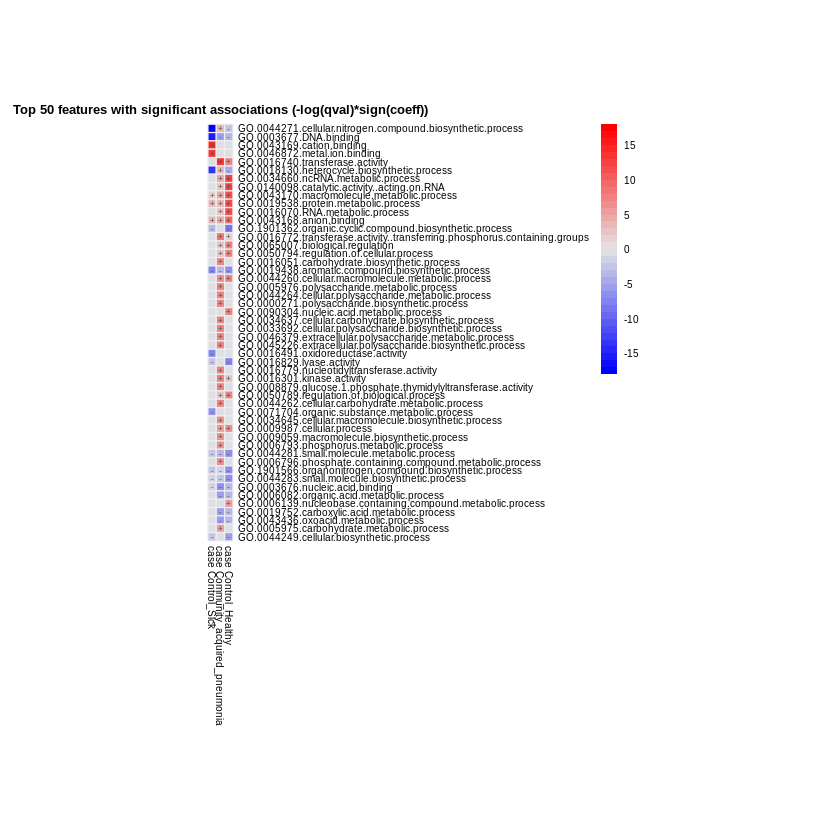

In [166]:
case<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./case",
  min_abundance = 0.01,
  min_prevalence = 0.01,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.25,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("case,COVID19"))

In [165]:
outcome<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./outcome",
  min_abundance = 0.001,
  min_prevalence = 0.001,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.77,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("outcome,Deceased"))

[1] "Creating output folder"
[1] "Creating output figures folder"
2020-11-22 05:04:01 INFO::Writing function arguments to log file
2020-11-22 05:04:01 INFO::Verifying options selected are valid
2020-11-22 05:04:01 INFO::Determining format of input files
2020-11-22 05:04:01 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-22 05:04:01 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-22 05:04:01 INFO::Formula for fixed effects: expr ~  outcome
2020-11-22 05:04:01 INFO::Filter data based on min abundance and min prevalence
2020-11-22 05:04:01 INFO::Total samples in data: 141
2020-11-22 05:04:01 INFO::Min samples required with min abundance for a feature not to be filtered: 0.141000
2020-11-22 05:04:02 INFO::Total filtered features: 13051
2020-11-22 05:04:02 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsolete.inheritan

2020-11-22 05:05:06 INFO::Creating boxplot for categorical data, outcome vs GO.0022904.respiratory.electron.transport.chain
2020-11-22 05:05:06 INFO::Creating boxplot for categorical data, outcome vs GO.0043177.organic.acid.binding
2020-11-22 05:05:06 INFO::Creating boxplot for categorical data, outcome vs GO.0031406.carboxylic.acid.binding
2020-11-22 05:05:06 INFO::Creating boxplot for categorical data, outcome vs GO.0016763.transferase.activity..transferring.pentosyl.groups
2020-11-22 05:05:07 INFO::Creating boxplot for categorical data, outcome vs GO.0030554.adenyl.nucleotide.binding
2020-11-22 05:05:07 INFO::Creating boxplot for categorical data, outcome vs GO.0032559.adenyl.ribonucleotide.binding
2020-11-22 05:05:07 INFO::Creating boxplot for categorical data, outcome vs GO.0005524.ATP.binding
2020-11-22 05:05:07 INFO::Creating boxplot for categorical data, outcome vs GO.0033293.monocarboxylic.acid.binding
2020-11-22 05:05:07 INFO::Creating boxplot for categorical data, outcome vs

In [162]:
#I need to figure out how to change how to pivot wider the case colum for an age analysis
age<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./age",
  min_abundance = 0.001,
  min_prevalence = 0.001,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.77,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case","age"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("case,COVID19"))

[1] 258  10

## MaAsLin2 outcome analyisis

### I'm gonna try it with the entire dataset at first just for fun to see what happens

In [167]:
bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_neg,outcome!="NA")
#bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_neg, case=="COVID19")
bac_pseq_outcome
sample_info_tab<-sample_data(bac_pseq_outcome)
sample_info_tab_phy <- sample_data(sample_info_tab)
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_outcome,design = ~ 1) 
deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
vst_trans_count_tab <- assay(deseq_counts_vst)
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_neg)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_outcome))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")
df_input_data2<-data.frame(t(otu_table(vst_physeq_comp)))
df_input_metadata2<-data.frame(sample_data(vst_physeq_comp))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

converting counts to integer mode



#### ok thats interesting it looks like it just through everything else into NA regardless of case... I guess lets trying it again with only covid cases

In [ ]:
Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./maaslin2_outcome",
  min_abundance = 0.001,
  min_prevalence = 0.001,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.95,
  random_effects = c("sample_name","publication"),
  fixed_effects = c("outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference="outcome,Deceased")

That made the results even less significant for some reason!  ok lets try with 

## MaAsLin2 outcome analysis (pruned samples)

In [167]:
bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_neg,outcome!="NA")
#bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_neg, case=="COVID19")
bac_pseq_outcome
sample_info_tab<-sample_data(bac_pseq_outcome)
sample_info_tab_phy <- sample_data(sample_info_tab)
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_outcome,design = ~ 1) 
deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
vst_trans_count_tab <- assay(deseq_counts_vst)
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_neg)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_outcome))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")
df_input_data2<-data.frame(t(otu_table(vst_physeq_comp)))
df_input_metadata2<-data.frame(sample_data(vst_physeq_comp))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

converting counts to integer mode



#### ok thats interesting it looks like it just through everything else into NA regardless of case... I guess lets trying it again with only covid cases

[1] "Warning: Deleting existing log file: ./maaslin2_outcome/maaslin2.log"
2020-11-22 05:19:00 INFO::Writing function arguments to log file
2020-11-22 05:19:00 INFO::Verifying options selected are valid
2020-11-22 05:19:00 INFO::Determining format of input files
2020-11-22 05:19:00 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-22 05:19:01 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-22 05:19:01 INFO::Formula for fixed effects: expr ~  outcome
2020-11-22 05:19:01 INFO::Filter data based on min abundance and min prevalence
2020-11-22 05:19:01 INFO::Total samples in data: 39
2020-11-22 05:19:01 INFO::Min samples required with min abundance for a feature not to be filtered: 0.039000
2020-11-22 05:19:01 INFO::Total filtered features: 13271
2020-11-22 05:19:01 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsolete.i

2020-11-22 05:19:31 INFO::Writing association plots (one for each significant association) to output folder: ./maaslin2_outcome
2020-11-22 05:19:31 INFO::Plotting associations from most to least significant, grouped by metadata
2020-11-22 05:19:31 INFO::Plotting data for metadata number 1, outcome
2020-11-22 05:19:31 INFO::Creating boxplot for categorical data, outcome vs GO.0030554.adenyl.nucleotide.binding
2020-11-22 05:19:31 INFO::Creating boxplot for categorical data, outcome vs GO.0032559.adenyl.ribonucleotide.binding
2020-11-22 05:19:32 INFO::Creating boxplot for categorical data, outcome vs GO.0005524.ATP.binding
2020-11-22 05:19:32 INFO::Creating boxplot for categorical data, outcome vs GO.0008152.metabolic.process
2020-11-22 05:19:32 INFO::Creating boxplot for categorical data, outcome vs GO.0008152.metabolic.process
2020-11-22 05:19:32 INFO::Creating boxplot for categorical data, outcome vs GO.0044419.interspecies.interaction.between.organisms
2020-11-22 05:19:32 INFO::Creati

2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0071941.nitrogen.cycle.metabolic.process
2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0071941.nitrogen.cycle.metabolic.process
2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0044249.cellular.biosynthetic.process
2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0044249.cellular.biosynthetic.process
2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0043207.response.to.external.biotic.stimulus
2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0008104.protein.localization
2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0008104.protein.localization
2020-11-22 05:19:40 INFO::Creating boxplot for categorical data, outcome vs GO.0033554.cellular.response.to.stress
2020-11-22 05:19:41 INFO::Creating boxplot for categorical data, outcom

2020-11-22 05:19:47 INFO::Creating boxplot for categorical data, outcome vs GO.0048585.negative.regulation.of.response.to.stimulus
2020-11-22 05:19:48 INFO::Creating boxplot for categorical data, outcome vs GO.0048585.negative.regulation.of.response.to.stimulus
2020-11-22 05:19:48 INFO::Creating boxplot for categorical data, outcome vs GO.0006996.organelle.organization
2020-11-22 05:19:48 INFO::Creating boxplot for categorical data, outcome vs GO.0006996.organelle.organization
2020-11-22 05:19:48 INFO::Creating boxplot for categorical data, outcome vs GO.0002683.negative.regulation.of.immune.system.process
2020-11-22 05:19:48 INFO::Creating boxplot for categorical data, outcome vs GO.0009399.nitrogen.fixation
2020-11-22 05:19:48 INFO::Creating boxplot for categorical data, outcome vs GO.0009399.nitrogen.fixation
2020-11-22 05:19:48 INFO::Creating boxplot for categorical data, outcome vs GO.0043412.macromolecule.modification
2020-11-22 05:19:49 INFO::Creating boxplot for categorical dat

2020-11-22 05:19:56 INFO::Creating boxplot for categorical data, outcome vs GO.0010556.regulation.of.macromolecule.biosynthetic.process
2020-11-22 05:19:56 INFO::Creating boxplot for categorical data, outcome vs GO.0010604.positive.regulation.of.macromolecule.metabolic.process
2020-11-22 05:19:56 INFO::Creating boxplot for categorical data, outcome vs GO.0051346.negative.regulation.of.hydrolase.activity
2020-11-22 05:19:56 INFO::Creating boxplot for categorical data, outcome vs GO.0034654.nucleobase.containing.compound.biosynthetic.process
2020-11-22 05:19:56 INFO::Creating boxplot for categorical data, outcome vs GO.0031347.regulation.of.defense.response
2020-11-22 05:19:56 INFO::Creating boxplot for categorical data, outcome vs GO.0031347.regulation.of.defense.response
2020-11-22 05:19:56 INFO::Creating boxplot for categorical data, outcome vs GO.0006508.proteolysis
2020-11-22 05:19:57 INFO::Creating boxplot for categorical data, outcome vs GO.0043067.regulation.of.programmed.cell.de

2020-11-22 05:20:03 INFO::Creating boxplot for categorical data, outcome vs GO.0039694.viral.RNA.genome.replication
2020-11-22 05:20:03 INFO::Creating boxplot for categorical data, outcome vs GO.0072528.pyrimidine.containing.compound.biosynthetic.process
2020-11-22 05:20:04 INFO::Creating boxplot for categorical data, outcome vs GO.0009966.regulation.of.signal.transduction
2020-11-22 05:20:04 INFO::Creating boxplot for categorical data, outcome vs GO.0090407.organophosphate.biosynthetic.process
2020-11-22 05:20:04 INFO::Creating boxplot for categorical data, outcome vs GO.0090407.organophosphate.biosynthetic.process
2020-11-22 05:20:04 INFO::Creating boxplot for categorical data, outcome vs GO.0051276.chromosome.organization
2020-11-22 05:20:04 INFO::Creating boxplot for categorical data, outcome vs GO.0051276.chromosome.organization
2020-11-22 05:20:04 INFO::Creating boxplot for categorical data, outcome vs GO.0042727.flavin.containing.compound.biosynthetic.process
2020-11-22 05:20:04

2020-11-22 05:20:11 INFO::Creating boxplot for categorical data, outcome vs GO.0032268.regulation.of.cellular.protein.metabolic.process
2020-11-22 05:20:11 INFO::Creating boxplot for categorical data, outcome vs GO.0032268.regulation.of.cellular.protein.metabolic.process
2020-11-22 05:20:11 INFO::Creating boxplot for categorical data, outcome vs GO.0098655.cation.transmembrane.transport
2020-11-22 05:20:11 INFO::Creating boxplot for categorical data, outcome vs GO.0098655.cation.transmembrane.transport
2020-11-22 05:20:12 INFO::Creating boxplot for categorical data, outcome vs GO.0030001.metal.ion.transport
2020-11-22 05:20:12 INFO::Creating boxplot for categorical data, outcome vs GO.0030001.metal.ion.transport
2020-11-22 05:20:12 INFO::Creating boxplot for categorical data, outcome vs GO.0090305.nucleic.acid.phosphodiester.bond.hydrolysis
2020-11-22 05:20:12 INFO::Creating boxplot for categorical data, outcome vs GO.0031331.positive.regulation.of.cellular.catabolic.process
2020-11-22

2020-11-22 05:20:19 INFO::Creating boxplot for categorical data, outcome vs GO.1901293.nucleoside.phosphate.biosynthetic.process
2020-11-22 05:20:19 INFO::Creating boxplot for categorical data, outcome vs GO.1901293.nucleoside.phosphate.biosynthetic.process
2020-11-22 05:20:19 INFO::Creating boxplot for categorical data, outcome vs GO.0075071.modulation.by.symbiont.of.host.autophagy
2020-11-22 05:20:19 INFO::Creating boxplot for categorical data, outcome vs GO.0000041.transition.metal.ion.transport
2020-11-22 05:20:19 INFO::Creating boxplot for categorical data, outcome vs GO.0000041.transition.metal.ion.transport
2020-11-22 05:20:20 INFO::Creating boxplot for categorical data, outcome vs GO.0015031.protein.transport
2020-11-22 05:20:20 INFO::Creating boxplot for categorical data, outcome vs GO.0015031.protein.transport
2020-11-22 05:20:20 INFO::Creating boxplot for categorical data, outcome vs GO.0052029.suppression.by.symbiont.of.host.signal.transduction.pathway
2020-11-22 05:20:20 I

2020-11-22 05:20:27 INFO::Creating boxplot for categorical data, outcome vs GO.0075044.positive.regulation.by.symbiont.of.host.autophagy
2020-11-22 05:20:27 INFO::Creating boxplot for categorical data, outcome vs GO.0009135.purine.nucleoside.diphosphate.metabolic.process
2020-11-22 05:20:27 INFO::Creating boxplot for categorical data, outcome vs GO.0009135.purine.nucleoside.diphosphate.metabolic.process
2020-11-22 05:20:27 INFO::Creating boxplot for categorical data, outcome vs GO.1905039.carboxylic.acid.transmembrane.transport
2020-11-22 05:20:27 INFO::Creating boxplot for categorical data, outcome vs GO.1905039.carboxylic.acid.transmembrane.transport
2020-11-22 05:20:27 INFO::Creating boxplot for categorical data, outcome vs GO.0061013.regulation.of.mRNA.catabolic.process
2020-11-22 05:20:28 INFO::Creating boxplot for categorical data, outcome vs GO.0009423.chorismate.biosynthetic.process
2020-11-22 05:20:28 INFO::Creating boxplot for categorical data, outcome vs GO.0009423.chorismat

2020-11-22 05:20:34 INFO::Creating boxplot for categorical data, outcome vs GO.0052170.suppression.by.symbiont.of.host.innate.immune.response
2020-11-22 05:20:34 INFO::Creating boxplot for categorical data, outcome vs GO.0039648.modulation.by.virus.of.host.protein.ubiquitination
2020-11-22 05:20:35 INFO::Creating boxplot for categorical data, outcome vs GO.0046031.ADP.metabolic.process
2020-11-22 05:20:35 INFO::Creating boxplot for categorical data, outcome vs GO.0046031.ADP.metabolic.process
2020-11-22 05:20:35 INFO::Creating boxplot for categorical data, outcome vs GO.0032775.DNA.methylation.on.adenine
2020-11-22 05:20:35 INFO::Creating boxplot for categorical data, outcome vs GO.0019056.modulation.by.virus.of.host.transcription
2020-11-22 05:20:35 INFO::Creating boxplot for categorical data, outcome vs GO.0006418.tRNA.aminoacylation.for.protein.translation
2020-11-22 05:20:35 INFO::Creating boxplot for categorical data, outcome vs GO.0009152.purine.ribonucleotide.biosynthetic.proces

2020-11-22 05:20:43 INFO::Creating boxplot for categorical data, outcome vs GO.0097367.carbohydrate.derivative.binding
2020-11-22 05:20:43 INFO::Creating boxplot for categorical data, outcome vs GO.0097367.carbohydrate.derivative.binding
2020-11-22 05:20:44 INFO::Creating boxplot for categorical data, outcome vs GO.0022803.passive.transmembrane.transporter.activity
2020-11-22 05:20:44 INFO::Creating boxplot for categorical data, outcome vs GO.0016757.transferase.activity..transferring.glycosyl.groups
2020-11-22 05:20:44 INFO::Creating boxplot for categorical data, outcome vs GO.0005342.organic.acid.transmembrane.transporter.activity
2020-11-22 05:20:44 INFO::Creating boxplot for categorical data, outcome vs GO.0005342.organic.acid.transmembrane.transporter.activity
2020-11-22 05:20:44 INFO::Creating boxplot for categorical data, outcome vs GO.0003916.DNA.topoisomerase.activity
2020-11-22 05:20:44 INFO::Creating boxplot for categorical data, outcome vs GO.0003916.DNA.topoisomerase.activ

2020-11-22 05:20:51 INFO::Creating boxplot for categorical data, outcome vs GO.0016616.oxidoreductase.activity..acting.on.the.CH.OH.group.of.donors..NAD.or.NADP.as.acceptor
2020-11-22 05:20:51 INFO::Creating boxplot for categorical data, outcome vs GO.0004457.lactate.dehydrogenase.activity
2020-11-22 05:20:51 INFO::Creating boxplot for categorical data, outcome vs GO.0004457.lactate.dehydrogenase.activity
2020-11-22 05:20:51 INFO::Creating boxplot for categorical data, outcome vs GO.0008242.omega.peptidase.activity
2020-11-22 05:20:51 INFO::Creating boxplot for categorical data, outcome vs GO.0016655.oxidoreductase.activity..acting.on.NAD.P.H..quinone.or.similar.compound.as.acceptor
2020-11-22 05:20:51 INFO::Creating boxplot for categorical data, outcome vs GO.0016773.phosphotransferase.activity..alcohol.group.as.acceptor
2020-11-22 05:20:51 INFO::Creating boxplot for categorical data, outcome vs GO.0008324.cation.transmembrane.transporter.activity
2020-11-22 05:20:51 INFO::Creating bo

2020-11-22 05:20:58 INFO::Creating boxplot for categorical data, outcome vs GO.0008757.S.adenosylmethionine.dependent.methyltransferase.activity
2020-11-22 05:20:58 INFO::Creating boxplot for categorical data, outcome vs GO.0004672.protein.kinase.activity
2020-11-22 05:20:58 INFO::Creating boxplot for categorical data, outcome vs GO.0046914.transition.metal.ion.binding
2020-11-22 05:20:59 INFO::Creating boxplot for categorical data, outcome vs GO.0004519.endonuclease.activity
2020-11-22 05:20:59 INFO::Creating boxplot for categorical data, outcome vs GO.0004252.serine.type.endopeptidase.activity
2020-11-22 05:20:59 INFO::Creating boxplot for categorical data, outcome vs GO.0008879.glucose.1.phosphate.thymidylyltransferase.activity
2020-11-22 05:20:59 INFO::Creating boxplot for categorical data, outcome vs GO.0008173.RNA.methyltransferase.activity
2020-11-22 05:20:59 INFO::Creating boxplot for categorical data, outcome vs GO.0015925.galactosidase.activity
2020-11-22 05:20:59 INFO::Creat

2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, outcome vs GO.0016896.exoribonuclease.activity..producing.5.phosphomonoesters
2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, outcome vs GO.0033284.ATPase.coupled.carboxylic.acid.transmembrane.transporter.activity
2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, outcome vs GO.0033284.ATPase.coupled.carboxylic.acid.transmembrane.transporter.activity
2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, outcome vs GO.0016887.ATPase.activity
2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, outcome vs GO.0008094.DNA.dependent.ATPase.activity
2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, outcome vs GO.0008094.DNA.dependent.ATPase.activity
2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, outcome vs GO.0015424.ATPase.coupled.amino.acid.transmembrane.transporter.activity
2020-11-22 05:21:06 INFO::Creating boxplot for categorical data, o

$results
                                                                                                                   feature
1                                                                                     GO.0030554.adenyl.nucleotide.binding
2                                                                                 GO.0032559.adenyl.ribonucleotide.binding
3                                                                                                   GO.0005524.ATP.binding
4                                                                                             GO.0008152.metabolic.process
5                                                                                             GO.0008152.metabolic.process
6                                                                    GO.0044419.interspecies.interaction.between.organisms
7                                                                                                  GO.0051179.localization
8                                                                                                  GO.0051179.localization
9                                                                                           GO.0022610.biological.adhesion
10                                                                                         GO.0050896.response.to.stimulus
11                                                                                        GO.0065007.biological.regulation
12                                                                                  GO.0055114.oxidation.reduction.process
13                                                                                GO.0009605.response.to.external.stimulus
14                                                                                   GO.0044237.cellular.metabolic.process
15                                                                                   GO.0044237.cellular.metabolic.process
16                                                                             GO.0050789.regulation.of.biological.process
17                                                                GO.0071840.cellular.component.organization.or.biogenesis
18                                                                                  GO.0009607.response.to.biotic.stimulus
19                                                                                    GO.0044238.primary.metabolic.process
20                                                                                   GO.0033036.macromolecule.localization
21                                                                                   GO.0033036.macromolecule.localization
22                                                                          GO.0071704.organic.substance.metabolic.process
23                                                                          GO.0071704.organic.substance.metabolic.process
24                                                                          GO.0006807.nitrogen.compound.metabolic.process
25                                                                          GO.0006807.nitrogen.compound.metabolic.process
26                                                                                GO.0051234.establishment.of.localization
27                                                                                GO.0051234.establishment.of.localization
28                                                                                                  GO.0032259.methylation
29                                                                                GO.0051716.cellular.response.to.stimulus
30                                                                                         GO.0009058.biosynthetic.process
31                                                                                         GO.0009058.biosynthetic.process
32                                                     

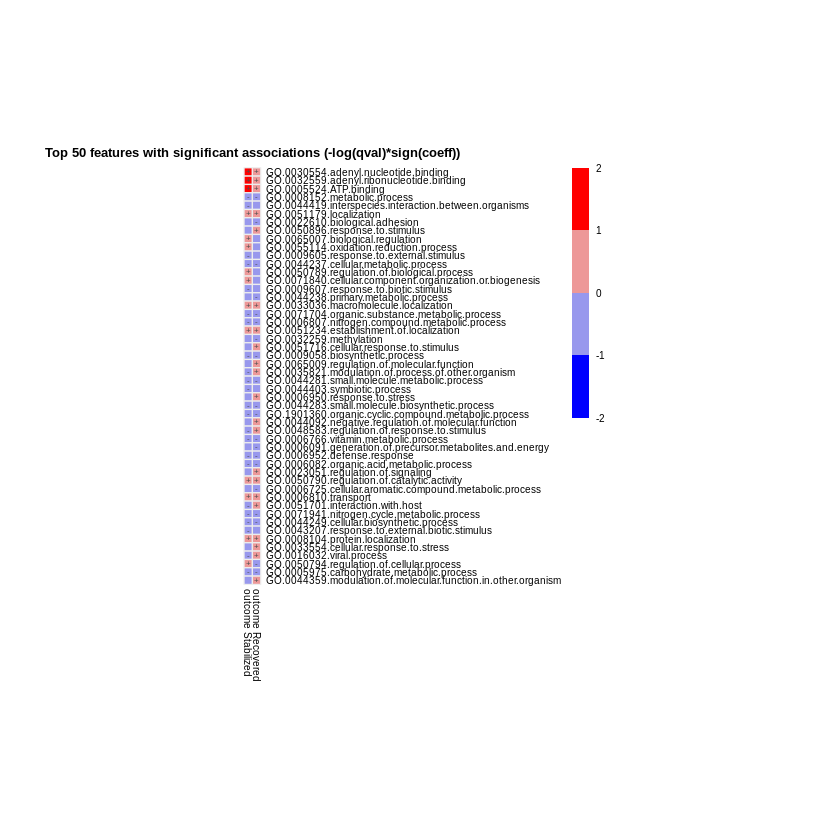

In [175]:
Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./maaslin2_outcome",
  min_abundance = 0.001,
  min_prevalence = 0.001,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.94,
  random_effects = c("sample_name","publication"),
  fixed_effects = c("outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference="outcome,Deceased")

OK OK OK OK NEXT I HAVE TO DO THIS ON THE COVID19 CASES ONLY (OR MAYBE ALL THE CASES AND JUST DELINEATE COVID19 BY OUTCOME) AND DO IT BY OUTCOME

## DMM modeling using the MaAslin2 derived terms

Ok, lets import the MaAsLin2 derived significant terms

In [ ]:
sig<-read.table("Significant_Go_terms_for_Beth_Maaslin2.txt",header = T,sep = "\t")
head(sig)

## DMM Preprocessing /filtering

Ok lets filter out the GO_tag mataches from our phyloseq object

In [ ]:
Terms<-sig$GO_Tag

In [ ]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg# [ 13846 taxa and 141 samples ]:

In [ ]:
bac_pseq_prune<-prune_taxa(x = bac_pseq_no_neg,taxa = Terms)
bac_pseq_prune #[ 92 taxa and 141 samples ]
#bac_pseq_prune <- prune_samples(sample_sums(bac_pseq_prune) > 1, bac_pseq_prune)
#bac_pseq_prune#[ 92 taxa and 141 samples ]
#bac_pseq_prune <- prune_taxa(taxa_sums(bac_pseq_prune) > 1, bac_pseq_prune)
#bac_pseq_prune #[ 92 taxa and 141 samples ]

ok lets rename our GO_terms again

In [ ]:
tax<-data.frame(tax_table(bac_pseq_prune))
names<-paste(rownames(tax),tax$name,sep="-")
length(names)
taxa_names(bac_pseq_prune)<-names

filter out the depth 0 mol fxn and bio proc, empty GO Terms, and empty samples

#### DMM modeling time

convert counts to a matrix

In [ ]:
dat <- abundances(bac_pseq_prune)
count <- as.matrix(t(dat))

Fit the dmm model

In [ ]:
fit <- mclapply(1:8, dmn, count = count, verbose=TRUE)

Check the model fit with different number of mixture componenets using standard information criteria

In [ ]:
lplc <- sapply(fit, laplace) # AIC / BIC / Laplace
aic  <- sapply(fit, AIC) # AIC / BIC / Laplace
bic  <- sapply(fit, BIC) # AIC / BIC / Laplace
plot(lplc, type="b", xlab="Number of Dirichlet Components", ylab="Model Fit")

In [ ]:
#identify the number of clusters that best fits the model

In [ ]:
best <- fit[[which.min(lplc)]]
best <-fit[[3]]
best

In [ ]:
#save.image(file = "go_terms_dmm.rdata")

#make a heatmap visualization of the cluster

log 2 Heatmap

In [ ]:
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =log2, lblwidth = 0.2 * nrow(count))

square root version

In [ ]:
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =sqrt, lblwidth = 0.2 * nrow(count))

print out the theta values

In [ ]:
mixturewt(best)

save the datasheet that show which GO terms contributed to each dmm group

In [ ]:
write.table(fitted(best),"GO_TERMS_DMM_contributions.tsv", sep="\t")

save a datasheet that identifies which sample belongs to which dmm group

In [ ]:
ass <- apply(mixture(best), 1, which.max)
write.table(ass,"GO_TERMS_DMM_groups.tsv",sep="")

In [ ]:
#add the dmm group to the metadata
sample_data(bac_pseq_prune)$dmn<-ass
bac_pseq_prune_comp<-microbiome::transform(bac_pseq_prune,"compositional")
#melt the phyloseq object into tidy form
tmp<-psmelt(bac_pseq_prune_comp)
tmp<-as_tibble(tmp)

In [ ]:
gghistogram(tmp,x = "Abundance",y = "..count..")+scale_x_log10() #move each dmm group into a colum of its own

In [ ]:
#tmp$log2Abundance<-log2(tmp$Abundance)

In [ ]:
#subset the dataset to only include the case, Go_term, count, and dmm group.
#obtain the avergage count for each Go term
#order the go terms from hight to lowest count

I added these filtering commands to pull out the counts with less than 1% relabund or greater tahn 22% (ie:molecular function)

In [ ]:
d2<-tmp %>%
  select(case,OTU,Abundance, dmn)%>%
  group_by(OTU,case, dmn) %>%
  summarise(avg = mean(Abundance)) %>%
  arrange(desc(avg))

In [ ]:
#d2$avg<-sqrt(d2$avg)

In [ ]:
d3<-tidyr::spread(d2,dmn, avg)

In [ ]:
#get the total count of the go terms and oder from greates to lowest

In [ ]:
d3<-tidyr::spread(d2,dmn,avg)
d3$tot<-rowSums(d3[3:5], na.rm = T)
d3<-d3%>%arrange(desc(tot))
d3$tot<-NULL
head(d3)

In [ ]:
d3<-d3%>%gather(data = d3,avg,3:5)
colnames(d3)<-c("name","case", "dmn","avg")

make the balloon plot

In [ ]:
d4<-d3%>%filter(avg>0.01)%>%arrange(name,case,dmn)
d4<-d4[1:108,]

In [ ]:
my_pal<-viridis(n = 256, alpha = 1, begin = 0, end = 1, direction = 1)

In [ ]:
options(repr.plot.width=14, repr.plot.height=10)
a<-ggplot(data = d4,mapping = aes(x = factor(dmn),y =reorder(name,avg),size=avg,color=avg))+
geom_point()+
#theme(text=element_text(size=20))+
scale_colour_gradientn(colours = my_pal,trans="log2")+
facet_grid(facets = ~ case)+
theme_minimal(base_size = 16)

a


In [ ]:
#    ggballoonplot(d4, y ="name",x = "dmn", size = "avg", facet.by = "case",fill = "avg",ggtheme = theme_minimal())+
#      guides(size = FALSE)+
#    font("y.text", size = 12)+scale_fill_viridis_c()

In [ ]:
#save.image("GO_TERM_Maaslin2_19_NOV_2020.rda")
#load.Rdata("GO_TERM_Maaslin2_19_NOV_2020.rda")

## DATA VISUALIZATION TIME and outcome comparison time

In [ ]:
sam<-as_tibble(sample_data(bac_pseq_no_neg))
tally(x = case~outcome,sam)
chisq.test(~outcome,sam)

ok lets do a binomial test to see if we can use this

In [ ]:
rec <-binom.test(~ outcome=="Recovered", data = sam)
dec <-binom.test(~ outcome=="Deceased", data = sam)
sta <-binom.test(~ outcome=="Stabilized", data = sam)
out_tbl<-tally(x = case~outcome,sam)
result2 <-chisq.test(table(out_tbl))
rec
dec
sta
out_tbl
result2
chisq(result2)

YAAAASSSSSS CASE ~OUTCOME Chi-squared TEST P=0.0517
LESGOOOO

That made the results even less significant for some reason!  ok lets try with 